<a href="https://colab.research.google.com/github/KBG1990/Estimating-quantum-non-Markovianity-using-machine-learning/blob/main/Machine_learning_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the libraries

In [ ]:
pip install -U keras # I had to update my keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [ ]:
import pandas as pd
import numpy as np

import os
import sys

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, LSTM
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import generic_utils # For progress bar

import keras.backend as K

# General support
import math
import tensorflow as tf


# Dimensionality reduction
import umap
from sklearn.manifold import TSNE


# Change the directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# change the drive according to your preference 
cd "/content/drive/My Drive/Colab Notebooks/NON_MARKOV_KBG/"

SyntaxError: ignored

#Upload the datasets

In [ ]:
Simulated_data = pd.read_csv('Sim_data_Pauli_concentrated.csv')
test_data = pd.read_csv('experimental_data_200.csv', header=None)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-eb41ccd18c0a>", line 1, in <module>
    Simulated_data = pd.read_csv('Sim_data_Pauli_concentrated.csv')
  File "/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py", line 676, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py", line 448, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py", line 880, in __init__
    self._make_engine(self.engine)
  File "/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py", line 1114, in _make_engine
    self._engine = CParserWrapper(self.f, **self.options)
  File "/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py", line 1891, in __init__
    self._reader = parsers.Tex

FileNotFoundError: ignored

In [ ]:
df1 = Simulated_data.iloc[:,:]
df1.drop("Unnamed: 0", axis=1, inplace=True)
df1 = df1.rename(columns = {'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, 'Labels':9}) ## This step is needed to match the names of the columns with the experimental data


## First I tried to train on the simulated data and test on the experimental data

Linear regression

In [ ]:
X_train = df1.iloc[:, 0:9].values
y_train = df1.iloc[:, -1].values

X_test = test_data.iloc[:,0:9].values
y_test = test_data.iloc[:,-1].values

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [ ]:
lm.fit(X_train, y_train)
print(lm.intercept_)
lm.coef_
predictions = lm.predict(X_test)

-1.268873819500263


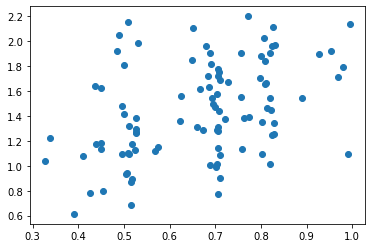

In [ ]:
plt.scatter(y_test,predictions)
# plt.plot(y_test,predictions, color=


A pretty bad result

In [ ]:
from sklearn import metrics
mae_1 = metrics.mean_absolute_error(y_test,predictions)
mse_1 = metrics.mean_squared_error(y_test,predictions)
rmse_1 = np.sqrt(metrics.mean_squared_error(y_test,predictions))
r2_1 = metrics.r2_score(y_test,predictions) # best is 1 
r2_1

-29.366229576499954

## Next I used a part of the experimental data to train along with the simulated data

### This time I randomly selected some part (60%) of the experimental data and train it with all the simulated data. Then test on the remaining 40% experimental data.


To randomly select 60% of the datasets, I first shuffle the rows and then select the first 60 rows. With different random selections the model is behaving differently. Maybe we can optimise this by shuffling a sufficient number of times first to maximise the entropy of the dataset.

In [ ]:
import sklearn as sk
Shuffled_test_data = sk.utils.shuffle(test_data) # Shuffle the experimental data before partitioning. A good shuffling is necessary for a better result. Maybe shuffle a few times to maximise the entropy.
df2 = Shuffled_test_data.iloc[0:120,0:10] # Taking 60 datapoints for training

Concatenating the simulated and 60% of the experimental data

In [ ]:
frame = [df1, df2]
Concatenated_data = pd.concat(frame,ignore_index=True,axis = 0)

Tst_set = Shuffled_test_data.iloc[120:200,0:10]
Test_set = Tst_set.reset_index(drop=True)


print(df1.iloc[0:2,:])
print(df2.iloc[0:2,:])
print(df2.shape)
print(Test_set.iloc[0:2,:])
print(Test_set.shape)

          0         1         2  ...         7         8         9
0  0.218618 -0.112468 -0.762967  ... -0.094856  0.760232  0.529036
1  0.217124 -0.117067 -0.764751  ... -0.068510  0.765381  0.501993

[2 rows x 10 columns]
           0         1        2        3  ...        6         7        8        9
197  0.32820 -0.141410 -0.91152  0.28259  ... -0.13044 -0.051381  0.95905  0.98893
5    0.27988 -0.083039 -0.73631  0.18542  ... -0.16469 -0.004461  0.84037  0.52676

[2 rows x 10 columns]
(120, 10)
         0         1        2         3  ...        6         7        8        9
0  0.27228 -0.050440 -0.81881  0.223870  ... -0.22821  0.029663  0.84492  0.53164
1  0.22029 -0.052535 -0.69923  0.057041  ... -0.17865  0.041375  0.77551  0.42012

[2 rows x 10 columns]
(80, 10)


In [ ]:
X_train = Concatenated_data.iloc[:,0:9].values
y_train = Concatenated_data.iloc[:,-1].values

X_test = Test_set.iloc[:,0:9].values
y_test = Test_set.iloc[:,-1].values


## Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [ ]:
lm.fit(X_train, y_train)
print(lm.intercept_)
lm.coef_
predictions = lm.predict(X_test)

-1.2639772386617598


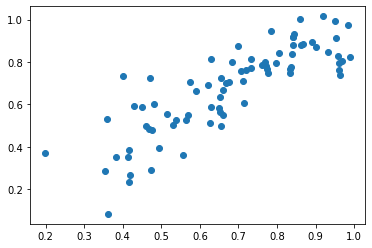

In [ ]:
plt.scatter(y_test,predictions)
# plt.plot(y_test,predictions, color='r')

A good result, motivation to try other algorithms

In [ ]:
# Maximum R2 score I got was 0.7136
from sklearn import metrics
mae_1 = metrics.mean_absolute_error(y_test,predictions)
mse_1 = metrics.mean_squared_error(y_test,predictions)
rmse_1 = np.sqrt(metrics.mean_squared_error(y_test,predictions))
r2_1 = metrics.r2_score(y_test,predictions) # best is 1 
r2_1

0.6483728781941436

## Polynomial regression

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
polynomial_features= PolynomialFeatures(degree=2)

In [ ]:
x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.fit_transform(X_test)

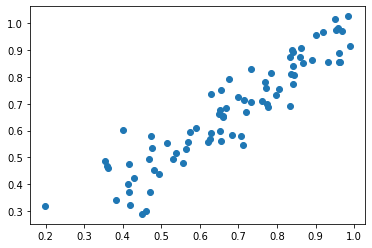

In [ ]:
model_poly = LinearRegression()
model_poly.fit(x_poly_train, y_train)
predictions2 = model_poly.predict(x_poly_test)
plt.scatter(y_test,predictions2)

In [ ]:
mae_2 = metrics.mean_absolute_error(y_test,predictions2)
mse_2 = metrics.mean_squared_error(y_test,predictions2)
rmse_2 = np.sqrt(metrics.mean_squared_error(y_test,predictions2))
r2_2 = r2_score(y_test,predictions2) # best is 1 
r2_2

0.8479867447140177

# Random Forest

In [ ]:
# Make a random forest model


# Defining the model

Random_Forest_model = RandomForestRegressor(max_depth=25, random_state=0, n_estimators=250)


# Compiling the model

Random_Forest_model.fit(X_train, y_train)

# Prediction and error

predictions_random_forest = Random_Forest_model.predict(X_test)

R2_score = r2_score(y_test , predictions_random_forest)
print('R2 score = ',R2_score)

R2 score =  0.559997793356145


# XGB boost

In [ ]:
from sklearn import metrics
#data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 100, alpha = 8, n_estimators = 250)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)


rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

R2_score = metrics.r2_score(y_test, preds)
print('R2 score =',R2_score)

[22:52:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.151853
R2 score = 0.36131888402047296


# Neural Network

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
# Make a model


NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
#NN_model.summary()

In [ ]:
#train the model, evaluate using 0.2 of data for validation comparison, run for 20 epochs, batch size of 32
NN_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 11564 samples, validate on 2892 samples
Epoch 1/20
11564/11564 [==============================] - 2s 160us/step - loss: 0.0960 - mean_absolute_error: 0.0960 - val_loss: 0.0508 - val_mean_absolute_error: 0.0508

Epoch 00001: val_loss improved from inf to 0.05083, saving model to Weights-001--0.05083.hdf5
Epoch 2/20
11564/11564 [==============================] - 1s 128us/step - loss: 0.0428 - mean_absolute_error: 0.0428 - val_loss: 0.0682 - val_mean_absolute_error: 0.0682

Epoch 00002: val_loss did not improve from 0.05083
Epoch 3/20
11564/11564 [==============================] - 2s 133us/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0582 - val_mean_absolute_error: 0.0582

Epoch 00003: val_loss did not improve from 0.05083
Epoch 4/20
11564/11564 [==============================] - 1s 129us/step - loss: 0.0294 - mean_absolute_error: 0.0294 - val_loss: 0.0647 - val_mean_absolute_error: 0.0647

Epoch 00004: val_loss did not improve from 0.05083
Epoch 5/20
11564/115

Got 90% R2  score

In [ ]:
predictions_NN_model = NN_model.predict(X_test)


R2_score = r2_score(y_test , predictions_NN_model)
print('R2_score = ',R2_score)

R2_score =  0.8916762860870466
